In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt

# import seaborn as sns

import io
import requests
from zipfile import ZipFile
from pathlib import Path
import calendar

f"Pandas version: {pd.__version__}"

'Pandas version: 2.2.3'

# Historical weather in Giessen

## Introduction


In this assignment we will explore some weather data measurements for Giessen (state of Hessia):

* Hourly temperature and relative humidity from 1950 to end of 2023.
* Hourly precipitation from 1997 to 2023.

The data has been collected by Deutscher Wetterdienst (DWD) and is publically available on https://opendata.dwd.de.

### Data source

The data is available on the open-data portal of the DWD: https://opendata.dwd.de 

### Download function

The function below will download are tarball containing the measurements as well as some metadata from a given URL. The tarball is extracted and placed in a specified directory.

In [2]:
def download_and_extract(
    url: str, 
    output_path: Path = Path('tmp/dwd')
) -> None:
    """download DWD climate data from url and extract."""
    output_path.mkdir(exist_ok=True, parents=True)

    (ZipFile(io.BytesIO(requests.get(url).content))
     .extractall(path=output_path)
    )

### Download the data

In [3]:
TMP_DIRECTORY = Path("_dwd")

#### Temperature and humidity data

*Data source: Deutscher Wetterdienst*

In [4]:
# Download the data and extract.
URL = (
    'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/'
    'air_temperature/historical/stundenwerte_TU_01639_19500101_20231231_hist.zip'
)

download_and_extract(url=URL, output_path=TMP_DIRECTORY / "temperature_and_humidity")

#### Precipitation data

*Data source: Deutscher Wetterdienst*

In [5]:
# Download the data and extract.
URL = (
    'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/'
    'precipitation/historical/stundenwerte_RR_01639_19970320_20231231_hist.zip'
)

download_and_extract(url=URL, output_path=TMP_DIRECTORY / "precipitation")

# Import and tweak

## Task 1: Temperature and humidity data

### Task 1.1: Import into `pd.DataFrame`

Import the data from the file [`produkt_tu_stunde_19500101_20231231_01639.txt`](./_dwd/temperature_and_humidity/produkt_tu_stunde_19500101_20231231_01639.txt) into a `pd.DataFrame`.

In [6]:
### BEGIN SOLUTION
df_th = pd.read_csv(TMP_DIRECTORY / "temperature_and_humidity/produkt_tu_stunde_19500101_20231231_01639.txt", 
                    sep=";",
                    usecols=["MESS_DATUM", "TT_TU", "RF_TU"])
### END SOLUTION

In [7]:
df_th.head()

MESS_DATUM  TT_TU  RF_TU
0  1950010101   -3.6   74.0
1  1950010102   -3.5   74.0
2  1950010103   -3.5   73.0
3  1950010104   -4.2   74.0
4  1950010105   -4.3   74.0

In [8]:
df_th.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648547 entries, 0 to 648546
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MESS_DATUM  648547 non-null  int64  
 1   TT_TU       648547 non-null  float64
 2   RF_TU       648547 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 14.8 MB


#### What do we have here?

* Dates in the format (year)(month)(day)(time in 24 hour format).
    * Dates will be imported as `int64` type by Pandas.
    * Dates have to be converted to suitable date format.
        * Must take into account the different time zones to which the dates refer.
* Measurements
    * Temperature (in ${}^{\circ}\textrm{C}$)
    * Relative humidity (in %)

#### Notes on measurement times

Refer to file `Metadaten_Parameter_tu_stunde_01639.html` for units and time zones for measurement date and time.

* Before 1996-10-01: MEZ time
* 1996-10-01 and later: UTC time

MEZ time is UTC time + 1h.

### Task 1.2: Tweak the data

Modify the dataframe in the following manner:

* Rename the column labels in a reasonable manner.
* Convert the datetimes at which the measurements were conducted to a proper Pandas `datetime` format (make them refer to UTC) and make this column the index of the DataFrame.
* Remove all lines with values missing due to failed measurements.
* Apply type conversions where appropriate.

We suggest placing all required code in the function below and then to call this function on the DataFrame imported previously, e.g.

```python
>>> df_th = tweak_temperature_and_humidity(df_th)
```

where 

```python
def tweak_temperature_and_humidity(df: pd.DataFrame) -> pd.DataFrame:
    # your code goes here
```

*Note*: This examples assumes that you have used the name `df_th` for the DataFrame that holds the dataset  with temperature and humidity measurements.

In [9]:
def tweak_temperature_and_humidity(df_):
    ### BEGIN SOLUTION
    def make_utc_datetime(df_):
        offsets = (df_["MESS_DATUM"] < 1996100100).astype(int)
        return (
            pd.to_datetime(df_["MESS_DATUM"], format="%Y%m%d%H") 
            - 
            pd.to_timedelta(offsets, unit="h")
        ).dt.tz_localize("UTC")
        
    return (
        df_
        # Convert all datetime to UTC
        .assign(datetime=make_utc_datetime(df_))
        .drop(columns=["MESS_DATUM"])
        # More expressive names for the data columns
        .rename(columns={
            "TT_TU": "temperature",
            "RF_TU": "humidity"
        })
        # Get rid of erroneous measurements
        .replace(-999, np.nan)
        .dropna()
        # Save some memory through type conversions
        .astype({
            "temperature": np.float32,
            "humidity": np.uint8,
        })
        # Make this dataset a time-series
        .set_index("datetime")
    )
    ### END SOLUTIONS

In [10]:
### BEGIN SOLUTION
df_th = tweak_temperature_and_humidity(df_th)
### END SOLUTION

In [11]:
df_th.head()

temperature  humidity
datetime                                        
1950-01-01 00:00:00+00:00         -3.6        74
1950-01-01 01:00:00+00:00         -3.5        74
1950-01-01 02:00:00+00:00         -3.5        73
1950-01-01 03:00:00+00:00         -4.2        74
1950-01-01 04:00:00+00:00         -4.3        74

In [12]:
df_th.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 647954 entries, 1950-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  647954 non-null  float32
 1   humidity     647954 non-null  uint8  
dtypes: float32(1), uint8(1)
memory usage: 8.0 MB


## Task 2: Precipitation data

### Task 2.1: Import data into a `pd.DataFrame`

Import the data for the station with ID "01639" (Giessen/Wettenberg) into a DataFrame. Refer to [this file](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/DESCRIPTION_obsgermany_climate_hourly_precipitation_historical_en.pdf) for a documentation of the dataset, in particular for the meaning of the columns contained in data file. 

Import all columns you consider useful. For those columns for which it is not that obvious (e.g. for the column with the datetimes it is quite apparent that we will need it) briefly comment why you consider it worth including.

*Note*: Also refer to the files in the download directory that contain additional information on the data and the measurements.

In [13]:
### BEGIN SOLUTION
df_p = pd.read_csv(
    TMP_DIRECTORY / "precipitation/produkt_rr_stunde_19970320_20231231_01639.txt", 
    sep=";",
    usecols=["MESS_DATUM", '  R1', "RS_IND", "WRTR"]
)
### END SOLUTION

In [14]:
df_p.head()

MESS_DATUM    R1  RS_IND  WRTR
0  1997032011   0.0       1  -999
1  1997032012   0.0       1  -999
2  1997032013   0.0       1  -999
3  1997032014   0.0       0  -999
4  1997032015   0.0       0  -999

In [15]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233564 entries, 0 to 233563
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MESS_DATUM  233564 non-null  int64  
 1     R1        233564 non-null  float64
 2   RS_IND      233564 non-null  int64  
 3   WRTR        233564 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 7.1 MB


### Task 2.2: Tweaking the data

Tweak the data in a similar manner as in the case of the temperature and humidity data.

#### Notes

* Be careful when removing "missing values" (as they are called in [the documentation of the dataset](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/DESCRIPTION_obsgermany_climate_hourly_precipitation_historical_en.pdf)). There might by many "missing values" in some colums but you will still want to keep the line in the DataFrame in order not to lose too many measurements. It is instructive to count the number of missing values in each column in order to have an overview.
* It is suggested to put the code used for tweaking the dataset in a dedicated function (e.g. with the name `tweak_precipitation`) and to call it on the previously imported DataFrame:

```python
>>> df_p = tweak_precipitation(df_p)
```

*Note*: It is assumed that you have previously named the variable referring to the dataframe containing the pressure data `df_p`.

In [16]:
def tweak_precipitation(df_):
    ### BEGIN SOLUTION
    return (
        df_
        .rename(columns={
             "MESS_DATUM": "datetime",
             "  R1": "precipitation", # mm units
             "RS_IND": "indicator",
             "WRTR": "precipitation_kind"
         })
         .assign(
             datetime=lambda df_: pd.to_datetime(df_["datetime"], format="%Y%m%d%H", utc=True),
             precipitation=lambda df_: df_.precipitation.replace(-999, np.nan)
         )
         .astype({
             "precipitation": np.float32,
             "indicator": "category",
             "precipitation_kind": "category"
         })
         .set_index("datetime")
    )
    ### END SOLUTION

In [17]:
### BEGIN SOLUTION
df_p = tweak_precipitation(df_p)
### END SOLUTION

In [18]:
df_p.head()

precipitation indicator precipitation_kind
datetime                                                             
1997-03-20 11:00:00+00:00            0.0         1               -999
1997-03-20 12:00:00+00:00            0.0         1               -999
1997-03-20 13:00:00+00:00            0.0         1               -999
1997-03-20 14:00:00+00:00            0.0         0               -999
1997-03-20 15:00:00+00:00            0.0         0               -999

In [19]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233564 entries, 1997-03-20 11:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   precipitation       232816 non-null  float32 
 1   indicator           233564 non-null  category
 2   precipitation_kind  233564 non-null  category
dtypes: category(2), float32(1)
memory usage: 3.1 MB


## Task 3: Data Exploration

In the following tasks you will asked to visualise certain aspects of the data.

Try to make the visualisations as "compelling" as possible by adding e.g. axes labels (with units if required), plot titles and reasonable scales. This will make you visualisations much easier to understand and expressive.

### Task 3.1: Merge dataframes

[Merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) the DataFrame containing the data for the temperature and the humidity with that containing the values for the amount of precipitation.

The new DataFrame (you might call it `df_weather`) shall also have the datetimes of the measurements in the index.

*Note*: 

* The time interval of available measurements in the *merged* DataFrame is determined by the DataFrame with the smaller interval.
* Try to use the new DataFrame in the following tasks. If you do not succeed in merging the two DataFrames it is also fine to use the individual DataFrames to solve the tasks.

In [20]:
df_weather = (
### BEGIN SOLUTION
    pd.merge(
        df_p.reset_index(),
        df_th.reset_index(),
        on="datetime"
    )
    .set_index("datetime")
### END SOLUTION
)

In [21]:
df_weather.head()

precipitation indicator precipitation_kind  \
datetime                                                                
1997-03-20 11:00:00+00:00            0.0         1               -999   
1997-03-20 12:00:00+00:00            0.0         1               -999   
1997-03-20 13:00:00+00:00            0.0         1               -999   
1997-03-20 14:00:00+00:00            0.0         0               -999   
1997-03-20 15:00:00+00:00            0.0         0               -999   

                           temperature  humidity  
datetime                                          
1997-03-20 11:00:00+00:00          2.5        79  
1997-03-20 12:00:00+00:00          2.5        83  
1997-03-20 13:00:00+00:00          3.3        66  
1997-03-20 14:00:00+00:00          3.3        65  
1997-03-20 15:00:00+00:00          3.5        63

In [22]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233046 entries, 1997-03-20 11:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   precipitation       232310 non-null  float32 
 1   indicator           233046 non-null  category
 2   precipitation_kind  233046 non-null  category
 3   temperature         233046 non-null  float32 
 4   humidity            233046 non-null  uint8   
dtypes: category(2), float32(2), uint8(1)
memory usage: 4.2 MB


### Task 3.2: Seasonal contributions to precipitation

Determine the contribution to the total yearly amount of precipitation of each [**meterological season**](https://www.dwd.de/DE/service/lexikon/Functions/glossar.html?lv3=101324&lv2=101304). Visualise the results in a single plot and make sure that the contributions of the single seasons can be distinguished.

/tmp/ipykernel_7701/1130009717.py:7: FutureWarning: The provided callable <function sum at 0x7f2e88428f40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .pivot_table(


<Axes: title={'center': 'yearly precipitation with contributions from seasons'}, xlabel='precipitation height / mm'>

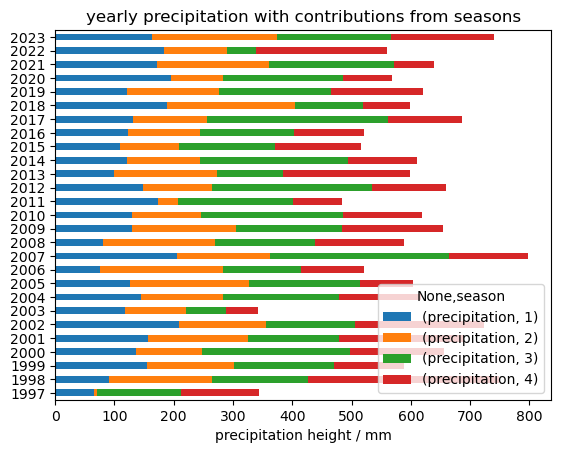

In [23]:
### BEGIN SOLUTION
(df_p
 .assign(
     year=lambda df_: df_.index.year,
     season=lambda df_: df_.index.month % 12 // 3 + 1
 )
 .pivot_table(
     index=["year", "season"],
     values="precipitation",
     aggfunc=np.sum
 )
 .unstack()
 .plot
 .barh(stacked=True, xlabel="precipitation height / mm", ylabel="", 
       title="yearly precipitation with contributions from seasons")
)
### END SOLUTION

### Task 3.3: The year 2003

By looking at the plot from the previous task it becomes obvious that the amount of precipitation in 2003 was much lower than in other years.

Search for hints in the data that support this observation. Generate two plots that further explain the observation (e.g. distributions, seasonal effects).

*Note*: In fact, the [summer of 2003](https://en.wikipedia.org/wiki/2003_European_heat_wave) has been quite special from a metereological point of view.

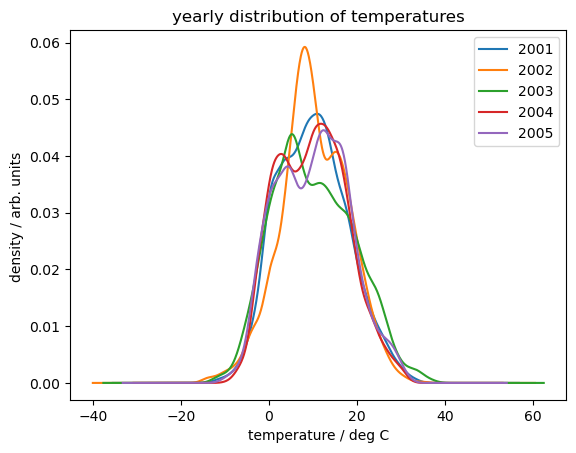

In [24]:
### BEGIN SOLUTION
fig, ax = plt.subplots(1, 1)

(df_weather
 .assign(year=lambda df_: df_.index.year)
 .query("2001 <= year <= 2005")
 .groupby("year")
 .temperature
 .plot(kind="kde", ax=ax, title="yearly distribution of temperatures",)
)

ax.set_xlabel("temperature / deg C")
ax.set_ylabel("density / arb. units ")
ax.legend()
### END SOLUTION

/tmp/ipykernel_7701/333826405.py:8: FutureWarning: The provided callable <function mean at 0x7f2e8842a340> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .pivot_table(


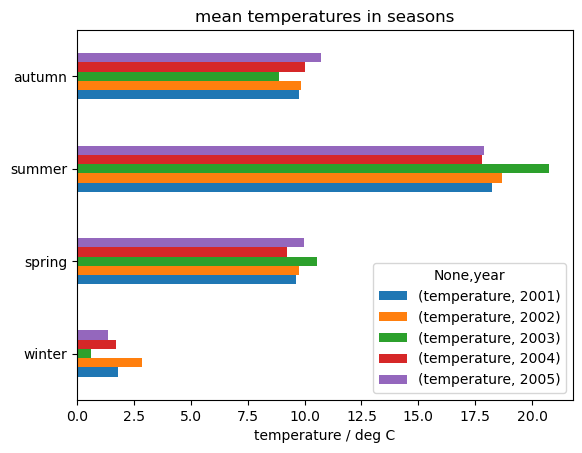

In [25]:
### BEGIN SOLUTION
ax = (df_weather
 .loc["2001":"2005"]
 .assign(
     year=lambda df_: df_.index.year,
     season=lambda df_: df_.index.month % 12 // 3 + 1
 )
 .pivot_table(
     index=["season", "year"],
     values="temperature",
     aggfunc=np.mean
 )
 .unstack()
 .plot(kind="barh", title="mean temperatures in seasons", 
       xlabel="temperature / deg C", ylabel="")
)

ax.set_yticklabels(("winter", "spring", "summer", "autumn"), rotation=0);
### END SOLUTION

### Task 3.4: Correlation between precipitation and humidity

Make a plot that correlates the amount of *actually fallen liquid precipitation* with the relative humidity. Also add temperature information in the *same* plot.

<Axes: title={'center': 'precipitation vs humidity'}, xlabel='humidity / %', ylabel='fallen liquid precipitation / mm'>

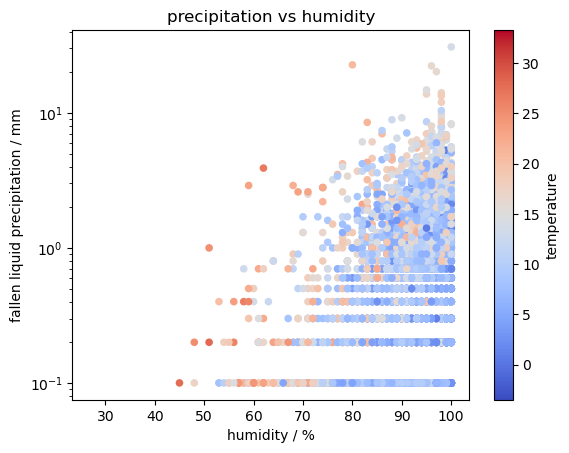

In [26]:
### BEGIN SOLUTION
(df_weather
 .query("precipitation_kind == 6")
 .plot
 .scatter(x="humidity", y="precipitation", logy=True,
          c="temperature",
          cmap="coolwarm",
          xlabel="humidity / %", ylabel="fallen liquid precipitation / mm",
          title="precipitation vs humidity")
)
### END SOLUTION

### Task 3.5: Correlation between humidity and temperature

* Make a plot that correlates the relative humidity with the temperature. Can you see a trend? 

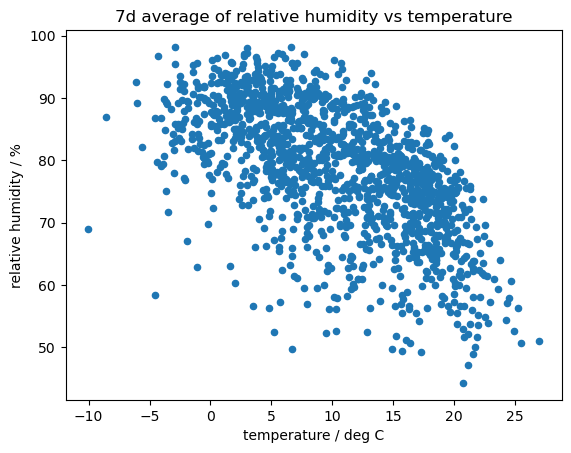

In [27]:
### BEGIN SOLUTION
fig, ax = plt.subplots(1, 1)

(df_weather
 .select_dtypes("number")
 .resample("7d")
 .mean()
 .plot
 .scatter(x="temperature", y="humidity",
          title="7d average of relative humidity vs temperature",
          xlabel="temperature / deg C", ylabel="relative humidity / %",
          ax=ax)
);
### END SOLUTION

* Make another plot that shows the (mean) temperature and the (mean) relative humidity over the course of the day.

<Axes: xlabel='hour of the day', ylabel='relative humidity / %'>

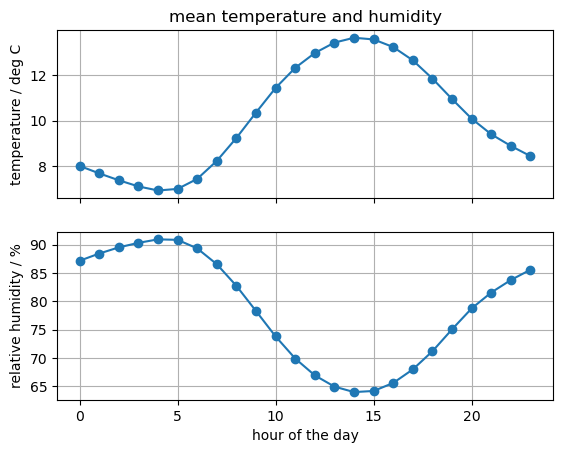

In [28]:
### BEGIN SOLUTION
fig, (ax1, ax2,) = plt.subplots(2, 1, sharex=True)

temperature_and_humidity_per_hour = (
    df_weather
     .assign(hour=lambda df_: df_.index.hour)
     .groupby("hour")
     .mean(numeric_only=True)
     [["humidity", "temperature"]]
)

(temperature_and_humidity_per_hour
 .temperature
 .plot(marker="o", ax=ax1, ylabel='temperature / deg C', 
       title="mean temperature and humidity", grid=True)
)

(temperature_and_humidity_per_hour
 .humidity
 .plot(marker="o", ax=ax2, ylabel='relative humidity / %', xlabel="hour of the day", grid=True)
)
### END SOLUTION